# Large Scale Machine Learning

In this hands-on we will work with machine learning on a large dataset. The dataset is a very famous image recognition dataset named MNIST ( https://en.wikipedia.org/wiki/MNIST_database ). The dataset contains a large number of grayscale images of handwritten digits. For this exercise we will use the machine learning algorithm called k-nearest neighbours (KNN) with k=1, which is one of the simplest machine learning algorithms. 

Start by loading the data into a Spark dataframe.

In [1]:
train_data=spark.read.csv("gs://big-data-course-datasets/mnist/mnist_train_sample.csv", header=True).cache()

We can take a look at the first row of the data to get an idea of how it looks.

In [2]:
train_data.take(1)

[Row(label='5', 1x1='0', 1x2='0', 1x3='0', 1x4='0', 1x5='0', 1x6='0', 1x7='0', 1x8='0', 1x9='0', 1x10='0', 1x11='0', 1x12='0', 1x13='0', 1x14='0', 1x15='0', 1x16='0', 1x17='0', 1x18='0', 1x19='0', 1x20='0', 1x21='0', 1x22='0', 1x23='0', 1x24='0', 1x25='0', 1x26='0', 1x27='0', 1x28='0', 2x1='0', 2x2='0', 2x3='0', 2x4='0', 2x5='0', 2x6='0', 2x7='0', 2x8='0', 2x9='0', 2x10='0', 2x11='0', 2x12='0', 2x13='0', 2x14='0', 2x15='0', 2x16='0', 2x17='0', 2x18='0', 2x19='0', 2x20='0', 2x21='0', 2x22='0', 2x23='0', 2x24='0', 2x25='0', 2x26='0', 2x27='0', 2x28='0', 3x1='0', 3x2='0', 3x3='0', 3x4='0', 3x5='0', 3x6='0', 3x7='0', 3x8='0', 3x9='0', 3x10='0', 3x11='0', 3x12='0', 3x13='0', 3x14='0', 3x15='0', 3x16='0', 3x17='0', 3x18='0', 3x19='0', 3x20='0', 3x21='0', 3x22='0', 3x23='0', 3x24='0', 3x25='0', 3x26='0', 3x27='0', 3x28='0', 4x1='0', 4x2='0', 4x3='0', 4x4='0', 4x5='0', 4x6='0', 4x7='0', 4x8='0', 4x9='0', 4x10='0', 4x11='0', 4x12='0', 4x13='0', 4x14='0', 4x15='0', 4x16='0', 4x17='0', 4x18='0', 

We can see that the first column of the data is the "label", which means that it is the digit shown in the image. The rest of the columns are the 28x28 pixels of the gray-scale image.

This way of looking at data is not very helpfull. Fortunately, we can visualize it in a better way. We define a function that takes a row of the data and constructs the gray-scale image.

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def showImage(row):
    print("Label: "+str(row["label"])) # Print the correct label of the image
    pixels=list(map(lambda x: int(x), row.asDict().values()))[1:] # Convert the Row-object to a raw list of integers
    image=np.array(pixels).reshape([28,28]) # Turn the list into a 2-dimensional array
    plt.imshow(image, cmap='gray_r') 
    plt.show()

Show the first ten rows as images:

Label: 5


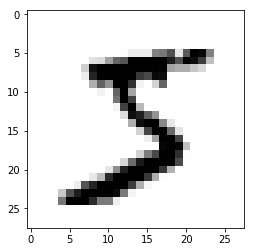

Label: 0


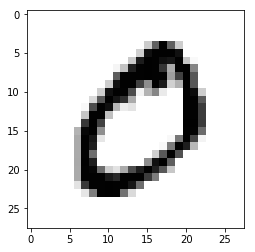

Label: 4


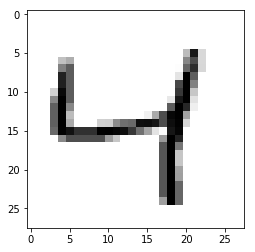

Label: 1


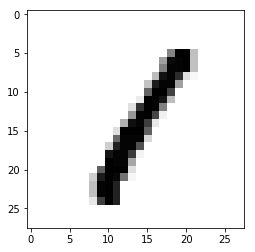

Label: 9


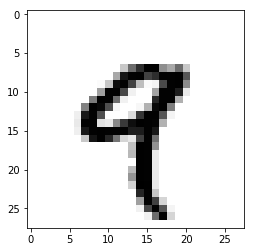

Label: 2


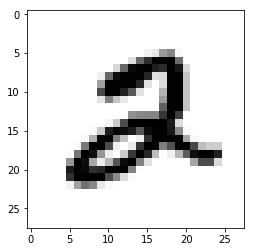

Label: 1


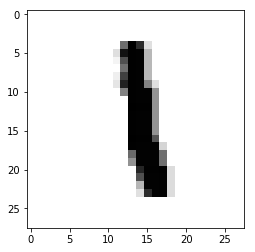

Label: 3


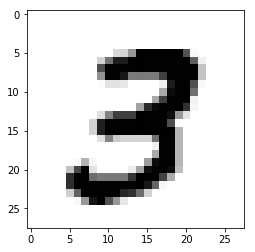

Label: 1


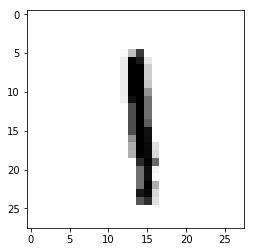

Label: 4


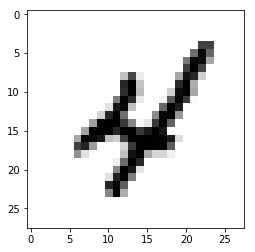

In [4]:
for row in train_data.take(10):
    showImage(row)

We are now ready to implement the KNN-algorithm for k=1. The algorithm simply classifies an image by finding the "closest" image in the training data and outputting that label. 

To see how well the algorithm works we load some test data, which has no overlap with the training data, but is otherwise similar.

In [5]:
test_data=spark.read.csv("gs://big-data-course-datasets/mnist/mnist_test_sample.csv", header=True).cache()

For the algorithm to work, we need a distance function that can return some measure of how different two images are. There are multiple different ways of specifying this distance, but one of the simplest is just to sum the numerical difference of each pixel.

In [6]:
def imageDistance(pixels1, pixels2):
    dist=0
    for i in range(len(pixels1)):
        dist+=abs(pixels1[i]-pixels2[i])
    return dist

Let us also define a little function for extracting the raw pixelvalues from a row:

In [7]:
def row2pixels(row):
    return list(map(lambda x: int(x), row.asDict().values()))[1:]

Lets test the function by comparing the first two images of the training data:

In [8]:
row1, row2 = train_data.take(2)
imageDistance(row2pixels(row1), row2pixels(row2))

29506

In [14]:
test_image=test_data.take(10)[1]

Label: 2


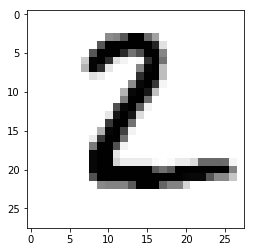

In [15]:
showImage(test_image)

In [16]:
def closestTrainingImage(test_image):
    return train_data.rdd \
       .map(lambda row: (imageDistance(row2pixels(row), row2pixels(test_image)), row)) \
       .sortByKey() \
       .take(1)[0][1]

In [17]:
closest=closestTrainingImage(test_image)

Label: 2


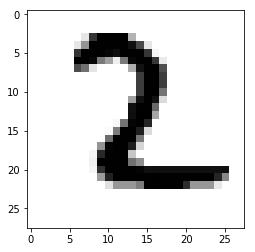

In [18]:
showImage(closest)